In [ ]:
import pandas as pd
from sodapy import Socrata

client = Socrata("data.cityofnewyork.us", None)

results = client.get("8h9b-rp9u", limit=100000)

results_df = pd.DataFrame.from_records(results)


In [ ]:
# Import required libraries for ST-DBSCAN
import numpy as np
from sklearn.cluster import DBSCAN
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

Dataset shape: (100000, 24)

Column names:
['arrest_key', 'arrest_date', 'pd_cd', 'pd_desc', 'ky_cd', 'ofns_desc', 'law_code', 'law_cat_cd', 'arrest_boro', 'arrest_precinct', 'jurisdiction_code', 'age_group', 'perp_sex', 'perp_race', 'x_coord_cd', 'y_coord_cd', 'latitude', 'longitude', 'lon_lat', ':@computed_region_efsh_h5xi', ':@computed_region_f5dn_yrer', ':@computed_region_yeji_bk3q', ':@computed_region_92fq_4b7q', ':@computed_region_sbqj_enih']

First few rows:
  arrest_key              arrest_date pd_cd                         pd_desc  \
0  298700791  2024-12-31T00:00:00.000   779  PUBLIC ADMINISTRATION,UNCLASSI   
1  298703567  2024-12-31T00:00:00.000   109        ASSAULT 2,1,UNCLASSIFIED   
2  298694784  2024-12-31T00:00:00.000   101                       ASSAULT 3   
3  298671937  2024-12-31T00:00:00.000   113           MENACING,UNCLASSIFIED   
4  298699270  2024-12-31T00:00:00.000   268              CRIMINAL MIS 2 & 3   

  ky_cd                       ofns_desc    law_code law

In [17]:
# Data preprocessing for ST-DBSCAN
# Clean and prepare the data
df_clean = results_df.dropna(subset=['latitude', 'longitude', 'arrest_date']).copy()
df_clean['arrest_date'] = pd.to_datetime(df_clean['arrest_date'])
df_clean['latitude'] = pd.to_numeric(df_clean['latitude'], errors='coerce')
df_clean['longitude'] = pd.to_numeric(df_clean['longitude'], errors='coerce')

# Filter out invalid coordinates (NYC bounds)
df_clean = df_clean[(df_clean['latitude'] > 40.0) & 
                   (df_clean['latitude'] < 41.0) & 
                   (df_clean['longitude'] > -75.0) & 
                   (df_clean['longitude'] < -73.0)]

# Sample data for processing
sample_size = min(100000, len(df_clean))
df_sample = df_clean.sample(n=sample_size, random_state=42).reset_index(drop=True)

print(f"Clean data: {len(df_clean)} rows")
print(f"Using sample: {len(df_sample)} rows")

Clean data: 99988 rows
Using sample: 99988 rows


In [20]:
def st_dbscan(data, eps_spatial, eps_temporal, min_samples):
    """ST-DBSCAN implementation for spatio-temporal clustering"""
    
    # Convert temporal data to days since earliest date
    earliest_date = data['arrest_date'].min()
    data_copy = data.copy()
    data_copy['days_since_start'] = (data['arrest_date'] - earliest_date).dt.days
    
    # Scale temporal dimension to spatial units
    temporal_scale = eps_spatial / eps_temporal
    
    # Create feature matrix: [latitude, longitude, scaled_temporal]
    features = np.column_stack([
        data_copy['latitude'].values,
        data_copy['longitude'].values,
        data_copy['days_since_start'].values * temporal_scale
    ])
    
    # Apply DBSCAN
    dbscan = DBSCAN(eps=eps_spatial, min_samples=min_samples)
    cluster_labels = dbscan.fit_predict(features)
    
    return cluster_labels

# ST-DBSCAN Parameters
eps_spatial = 0.005     # ~1km spatial radius
eps_temporal = 7      # 14 days temporal window  
min_samples = 15# Minimum 5 incidents per cluster

# Apply ST-DBSCAN
cluster_labels = st_dbscan(df_sample, eps_spatial, eps_temporal, min_samples)
df_sample['cluster'] = cluster_labels

# Results
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = list(cluster_labels).count(-1)

print(f"ST-DBSCAN Results:")
print(f"Clusters found: {n_clusters}")
print(f"Points in clusters: {len(df_sample) - n_noise} ({((len(df_sample) - n_noise) / len(df_sample)) * 100:.1f}%)")
print(f"Noise points: {n_noise}")

ST-DBSCAN Results:
Clusters found: 175
Points in clusters: 81961 (82.0%)
Noise points: 18027


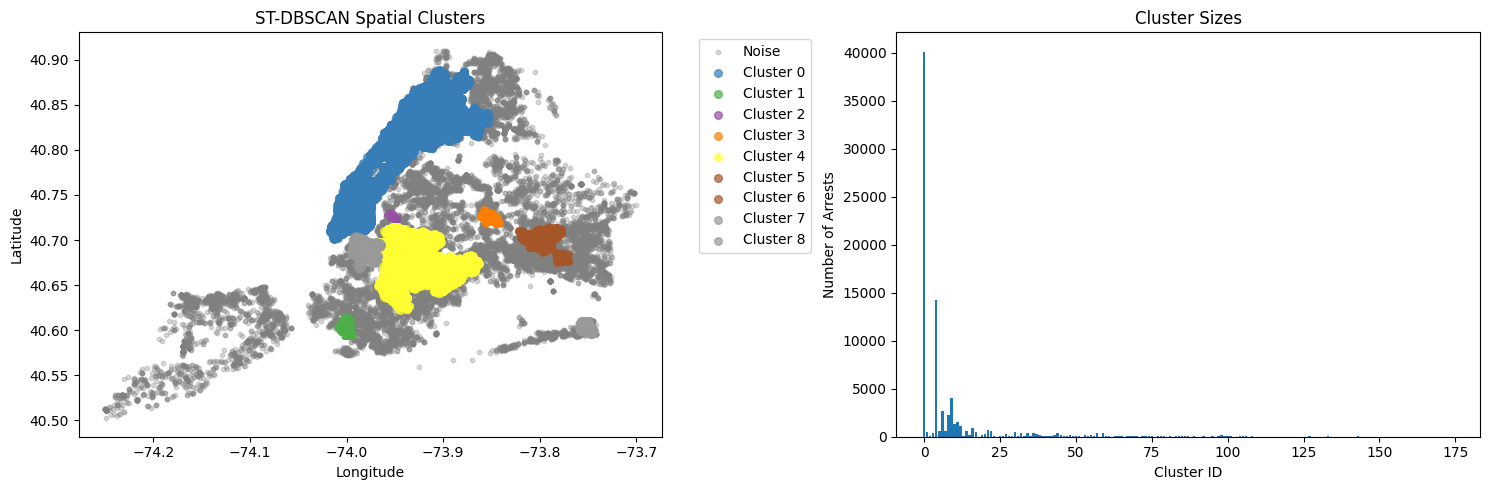

In [21]:
# Visualization of ST-DBSCAN results
plt.figure(figsize=(15, 5))

# 1. Spatial visualization
plt.subplot(1, 2, 1)
unique_clusters = sorted(df_sample['cluster'].unique())
colors = plt.cm.Set1(np.linspace(0, 1, min(len(unique_clusters), 10)))

for i, cluster_id in enumerate(unique_clusters[:10]):  # Show max 10 clusters for clarity
    cluster_data = df_sample[df_sample['cluster'] == cluster_id]
    if cluster_id == -1:
        plt.scatter(cluster_data['longitude'], cluster_data['latitude'], 
                   c='gray', alpha=0.3, s=10, label='Noise')
    else:
        plt.scatter(cluster_data['longitude'], cluster_data['latitude'],
                   c=[colors[i]], s=30, alpha=0.7, label=f'Cluster {cluster_id}')

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('ST-DBSCAN Spatial Clusters')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# 2. Cluster sizes
plt.subplot(1, 2, 2)
if n_clusters > 0:
    cluster_sizes = df_sample[df_sample['cluster'] != -1]['cluster'].value_counts().sort_index()
    plt.bar(range(len(cluster_sizes)), cluster_sizes.values)
    plt.xlabel('Cluster ID')
    plt.ylabel('Number of Arrests')
    plt.title('Cluster Sizes')

plt.tight_layout()
plt.show()

In [22]:
# Analysis of top clusters
if n_clusters > 0:
    clustered_data = df_sample[df_sample['cluster'] != -1]
    top_clusters = clustered_data['cluster'].value_counts().head(5)
    
    print("=== TOP 5 LARGEST CLUSTERS ===")
    for i, (cluster_id, size) in enumerate(top_clusters.items(), 1):
        cluster_data = df_sample[df_sample['cluster'] == cluster_id]
        
        lat_center = cluster_data['latitude'].mean()
        lon_center = cluster_data['longitude'].mean()
        date_start = cluster_data['arrest_date'].min()
        date_end = cluster_data['arrest_date'].max()
        duration_days = (date_end - date_start).days
        
        top_offense = cluster_data['ofns_desc'].value_counts().iloc[0]
        top_offense_name = cluster_data['ofns_desc'].value_counts().index[0]
        
        print(f"\nCluster {cluster_id}:")
        print(f"  Size: {size} arrests")
        print(f"  Location: ({lat_center:.4f}, {lon_center:.4f})")
        print(f"  Duration: {duration_days} days")
        print(f"  Top offense: {top_offense_name} ({top_offense} cases)")
else:
    print("No clusters found. Try adjusting parameters.")

=== TOP 5 LARGEST CLUSTERS ===

Cluster 0:
  Size: 40134 arrests
  Location: (40.7988, -73.9431)
  Duration: 141 days
  Top offense: ASSAULT 3 & RELATED OFFENSES (5282 cases)

Cluster 4:
  Size: 14264 arrests
  Location: (40.6725, -73.9241)
  Duration: 141 days
  Top offense: ASSAULT 3 & RELATED OFFENSES (1968 cases)

Cluster 9:
  Size: 4073 arrests
  Location: (40.7473, -73.8741)
  Duration: 141 days
  Top offense: ASSAULT 3 & RELATED OFFENSES (631 cases)

Cluster 6:
  Size: 2702 arrests
  Location: (40.7036, -73.7986)
  Duration: 141 days
  Top offense: PETIT LARCENY (343 cases)

Cluster 8:
  Size: 2307 arrests
  Location: (40.6900, -73.9822)
  Duration: 140 days
  Top offense: PETIT LARCENY (388 cases)
